In [1]:
from abtem import *
from ase import Atoms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 

# Relative atomic contrast

Calculates the relative atomic STEM contrast and fits a power law.

In [24]:
def atomic_potential(Z):
    atoms = Atoms([Z], positions=[(2.5,2.5,2.5)], cell=(5,5,5))
    return Potential(atoms, sampling=.1, slice_thickness=1, 
                     parametrization='lobato', projection='finite')

def powerlaw(x, amplitude, power):
    return amplitude * (x ** power)

def fit_power_law(xdata, ydata):
    logxdata = np.log10(xdata)
    logydata = weights = np.log10(ydata)

    fitfunc = lambda p, x: p[0] + p[1] * x   
    errfunc = lambda p, x, y, weights: (y - fitfunc(p, x)) / weights

    pinit = [1.0, 2.0]
    result = optimize.leastsq(errfunc, pinit, args=(logxdata, logydata, weights))

    amplitude = 10. ** result[0][0]
    power = result[0][1]
    
    return amplitude, power

In [36]:
kn(0, 0)

inf

In [35]:
from scipy.special import kn

def projected_potential(r, p):
    return 2 * (2 * p[0][:, None] / p[1][:, None] * kn(0, r[None] * p[1][:, None]) +
                p[0][:, None] * r[None] * kn(1, r[None] * p[1][:, None])).sum(0)

from abtem.parametrizations import load_lobato_parameters
p = load_lobato_parameters()


r = np.linspace(0,1,10)

projected_potential(r, p[8])

<ipython-input-35-60b405397e97>:5: RuntimeWarning: invalid value encountered in multiply
  p[0][:, None] * r[None] * kn(1, r[None] * p[1][:, None])).sum(0)


array([       nan, 4.91176215, 2.54112784, 1.42111412, 0.8123855 ,
       0.47017918, 0.27515353, 0.16284521, 0.09744874, 0.05890235])

In [25]:
Zs = np.arange(1, 90, 1, dtype=np.int)

intensities = []

for Z in tqdm(Zs):
    potential = atomic_potential(Z)
    
    intensities.append(potential.build().array.max())
    

<ipython-input-25-a5f425cf7485>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Zs = np.arange(1, 90, 1, dtype=np.int)


  0%|          | 0/89 [00:00<?, ?it/s]

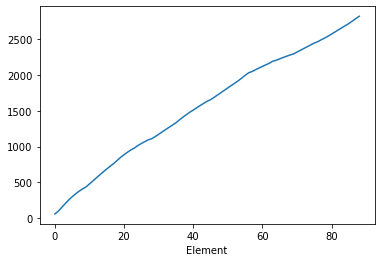

In [26]:
plt.plot(intensities)
plt.xlabel('Element');

In [254]:
probe = Probe(energy=300e3, semiangle_cutoff=30)

detector = AnnularDetector(45, 200)

In [255]:
Zs = np.arange(1, 90, 1, dtype=np.int)

intensities = []

for Z in tqdm(Zs):
    potential = atomic_potential(Z)

    position = (potential.extent[0] / 2, potential.extent[1] / 2)

    exit_wave = probe.multislice(position, potential, pbar=False)
    
    intensities.append(detector.detect(exit_wave)[0])
    
intensities = np.array(intensities)

best fitting powerlaw: 0.000060 * Z ** 1.721703


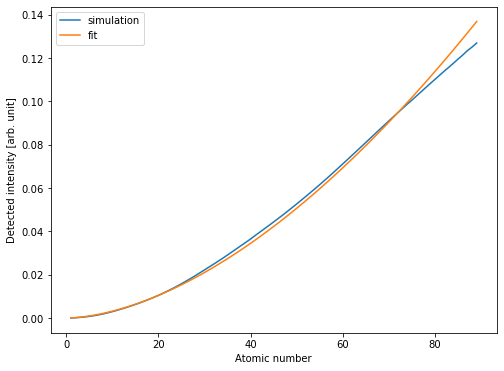

In [256]:
amplitude, power = fit_power_law(Zs, intensities)

print(f'best fitting powerlaw: {amplitude:.6f} * Z ** {power:.6f}')

plt.figure(figsize=(8,6))
plt.plot(Zs, intensities, label='simulation')
plt.plot(Zs, powerlaw(Zs, amplitude, power), label='fit')
plt.xlabel('Atomic number')
plt.ylabel('Detected intensity [arb. unit]')
plt.legend();